## The Notebook for New centrality validation

Part I: Leave-one-out validation

Part II: Tissue-enrichment validation

In [226]:
import sys

import pandas 
import scipy
import numpy

import matplotlib.pyplot
import seaborn

sys.path.append("../scripts")
import utils

In [227]:
def parse_results(results_file):
    # load scores
    results = {}

    with open(results_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            ENSG, gene, score = line_splitted
            results[ENSG] = float(score)

    return results

In [228]:
def parse_leave_one_out(results_file):
    # load left-out scores
    results_left_out = {}

    with open(results_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            ENSG, gene, score = line_splitted
            results_left_out[ENSG] = float(score)
        
    return results_left_out

In [229]:
def format_pvalue(pvalue):
    return '{:.2e}'.format(pvalue)

In [230]:
def compare_scores(results, results_left_out):
    results = results.copy()
    for left_out in results_left_out:
        del results[left_out]

    df_results = pandas.DataFrame.from_dict(results, 
                                       orient='index', 
                                       columns=['score'])
    df_results['group'] = "Proteins in interactome"

    df_results_left_out = pandas.DataFrame.from_dict(results_left_out, 
                                                    orient='index', 
                                                    columns=['score'])

    df_results_left_out['group'] = 'Left-out proteins'

    # concatenate dataframes for comparison
    df_compare = pandas.concat([df_results, df_results_left_out])

    # check if left-out genes score highter than non-causal genes
    _, pvalue = scipy.stats.ranksums(df_results['score'].values, df_results_left_out['score'].values, alternative='less')

    pvalue_thresh = format_pvalue(pvalue)

    return df_compare, pvalue_thresh

In [231]:
def geneName_to_ENSG(genes_file):
    genes = {}

    f = open(genes_file, 'r')
    
    # skip header
    next(f)

    for line in f:
        line_splitted = line.rstrip().split('\t')
        gene_name, ENSG = line_splitted

        genes[gene_name] = ENSG
    
    return genes

In [232]:
def intersection(list_1, list_2):
    return list(set(list_1) & set(list_2))

In [233]:
def take_top_percent(list, percent):
    num_elements = int(len(list) * percent/100)
    num_elements = max(num_elements, 1)
    
    return list[:num_elements], list[num_elements:]

#### Set parameters

In [1097]:
PHENOTYPE = "HYPCARDIOM" # to choose: MMAF, NOA, DILCARDIOM, HYPCARDIOM, ALS, BC (breast cancer), CRC (colon cancer)
ALPHA = 0.1
D_MAX = 10
ALPHA_NORM = 10

NEW_CENTRALITY_VERSION = "v8"

#### Parse interactome

In [1098]:
interactome = utils.parse_interactome(interactome_file="/home/kubicaj/calc/input/Interactome_human.sif")

### Part I: Leave-one-out validation

#### Load New centrality scores and leave-one-out results

In [1099]:
alpha = str(ALPHA).replace('.', '')
results = parse_results(f"/home/kubicaj/calc/output/New_centrality_{NEW_CENTRALITY_VERSION}/{PHENOTYPE}/alpha{alpha}_dmax{D_MAX}_alphanorm_{ALPHA_NORM}/scores.tsv")
results_leave_one_out = parse_leave_one_out(f"/home/kubicaj/calc/output/New_centrality_{NEW_CENTRALITY_VERSION}/{PHENOTYPE}/alpha{alpha}_dmax{D_MAX}_alphanorm_{ALPHA_NORM}/scores_leave_one_out.tsv")

In [1100]:
df_compare, p_value = compare_scores(results, results_leave_one_out)

print(f"p-value = {p_value}")

p-value = 5.16e-26


phenotype = HYPCARDIOM 
alpha = 0.1 
d = 10 
alpha_norm = 10


/tmp/ipykernel_6799/878206629.py:6: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  seaborn.boxplot(data=df_compare, x='group', y='score', hue='group', palette=seaborn.husl_palette(h=.5))


(0.0, 18.0)

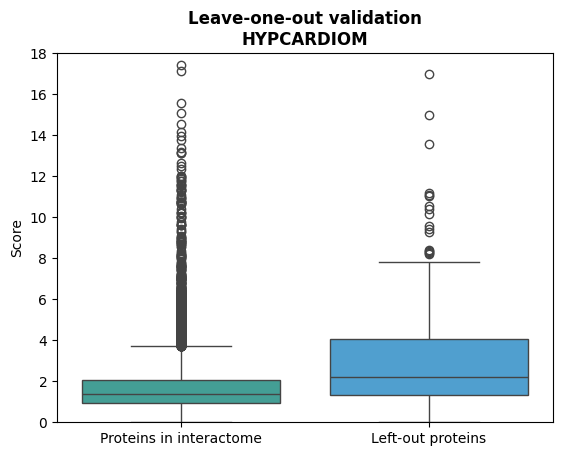

In [1101]:
# plot scores of non-causal genes vs. left-out genes

# sanity check for parameters:
print(f"phenotype = {PHENOTYPE} \nalpha = {ALPHA} \nd = {D_MAX} \nalpha_norm = {ALPHA_NORM}")

seaborn.boxplot(data=df_compare, x='group', y='score', hue='group', palette=seaborn.husl_palette(h=.5))

# PHENOTYPE = "Dilated cardiomyopathy"
matplotlib.pyplot.title(f"Leave-one-out validation\n{PHENOTYPE}", weight='bold', fontsize=12)
matplotlib.pyplot.ylabel("Score")
matplotlib.pyplot.xlabel("")
matplotlib.pyplot.ylim(0, 18)

# matplotlib.pyplot.savefig(f"/home/kubicaj/calc/Figures/Leave-one-out/{PHENOTYPE}", dpi=1000)

In [1102]:
# get top 10 high-scoring genes (ENSGs)
results_sorted = sorted(results.keys(), key=lambda item: results[item], reverse=True)
results_sorted[:10]

['ENSG00000134056',
 'ENSG00000120093',
 'ENSG00000224877',
 'ENSG00000065518',
 'ENSG00000185267',
 'ENSG00000125356',
 'ENSG00000163959',
 'ENSG00000186020',
 'ENSG00000151366',
 'ENSG00000059691']

#### Analyze new candidates (if have any)

In [1103]:
genes = geneName_to_ENSG("/home/kubicaj/calc/input/canonicalGenes.tsv")

# New candidates from 13/02/2024
new_candidates_names = ['CLHC1', 'PHF20', 'NUSAP1', 'CDC20B', 'FAM221A', 'GALR3', 'LRRC9', 'KIF27', 'ZNF208', 'C6orf118', 'CCDC66', 'CCNA1', 'DDX43', 'FSCB', 'FHAD1', 'LRGUK', 'MYCBPAP', 'MYH7B', 'PCDHB15', 'SAMD15', 'SPACA9', 'SPATA24', 'SPATA6', 'TSSK4', 'TTLL2']

# Candidates for ALS from Neurohack
# new_candidates_names = ['BCS1L', 'CAMLG', 'PSMB3', 'SARM1', 'SCFD1', 'TMEM175', 'WIPI2']

# Li et al 2013
# new_candidates_names = ['MYL2', 'MYL3', 'TNNI1', 'MYH14', 'NEB', 'TNNI2', 'GJA1', 'ACTA1', 'MYL1', 'TNNC2']

new_candidates_ENSG = [genes.get(n) for n in new_candidates_names]
new_candidates = [n for n in new_candidates_ENSG if n in interactome]

In [1104]:
# check scores of new candidates
scores_new_candidates = {n: results.get(n) for n in new_candidates}

In [1105]:
scores_new_candidates

{'ENSG00000162994': 1.6683712043060666,
 'ENSG00000025293': 3.9963901628370464,
 'ENSG00000164287': 1.172490376467604,
 'ENSG00000188732': 1.1265714844469852,
 'ENSG00000128310': 1.0598884372644934,
 'ENSG00000165115': 3.0528663956165567,
 'ENSG00000180376': 1.5547540587689934,
 'ENSG00000133101': 1.2043533327955929,
 'ENSG00000080007': 0.0,
 'ENSG00000142621': 3.8626495840458284,
 'ENSG00000136449': 1.3325877863027693,
 'ENSG00000078814': 1.082645482162417,
 'ENSG00000165698': 2.040698693689698,
 'ENSG00000170469': 1.3286459982330514,
 'ENSG00000132122': 1.9317207550396025,
 'ENSG00000139908': 2.6627431525733805,
 'ENSG00000120440': 0.548994180736709}

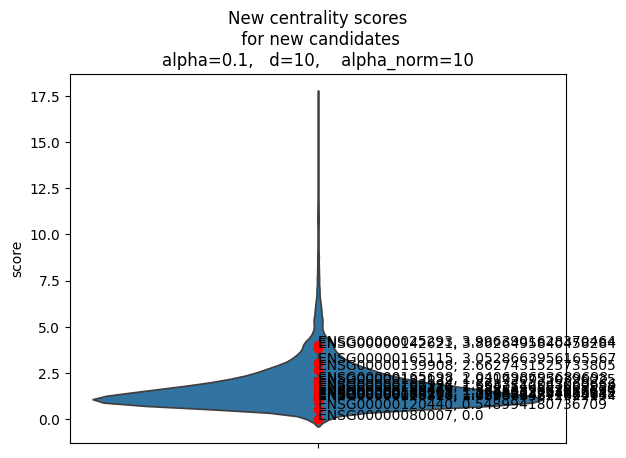

In [1106]:
# plot the scores distribution with new candidates scores

seaborn.violinplot(data=df_compare, y='score')
matplotlib.pyplot.title(f"New centrality scores\n for new candidates\nalpha={ALPHA},   d={D_MAX},    alpha_norm={ALPHA_NORM}")

for candidate, score in scores_new_candidates.items():
    matplotlib.pyplot.plot(score, 'or')
    matplotlib.pyplot.text(0, score, s=f"{candidate}, {score}")

### Part II: Tissue-enrichment (GTEx): "Are tissue-specific genes significantly enriched in the predicted causal genes?"

In [1107]:
results_sorted = sorted(results.keys(), key=lambda item: results[item], reverse=True)

scores_sorted = [results[node] for node in results_sorted]

In [1108]:
# TISSUE = "testis"
# PRED_CAUSAL_DEFINITION = 10 # [%]
# TISSUE_DEFINITION = 10 # [%]

TISSUE = "heart"
PRED_CAUSAL_DEFINITION = 10 # [%]
TISSUE_DEFINITION = 10 # [%]

# TISSUE = "colon"
# PRED_CAUSAL_DEFINITION = 10 # [%]
# TISSUE_DEFINITION = 10 # [%]

In [1109]:
# get top PRED_CAUSAL_DEFINITION[%] of highest-scoring genes from New centrality
pred_causal, non_pred_causal = take_top_percent(results_sorted, PRED_CAUSAL_DEFINITION)

In [1110]:
# load tissue expression from grexome-TIMC-Secondary-interactome/GTEX_Data
GTEx_tissue = {}

with open(f"/home/kubicaj/calc/grexome-TIMC-Secondary-interactome/GTEX_Data/E-MTAB-5214-query-results-{TISSUE}-ratio.tpms.tsv") as f:
    # skip header
    for _ in range(5):
        next(f)
    for line in f:
        split_line = line.rstrip().split('\t')

        ENSG, tissue_ratio, *_ = split_line

        if ENSG in interactome.nodes():
            GTEx_tissue[ENSG] = float(tissue_ratio)

In [1111]:
# # get top TISSUE_DEFINITION[%] of genes expressed in the tissue
GTEx_tissue_sorted = sorted(GTEx_tissue.keys(), key=lambda item: GTEx_tissue[item], reverse=True)
tissue_enriched, non_tissue_enriched = take_top_percent(GTEx_tissue_sorted, TISSUE_DEFINITION)

In [1112]:
# construct a contingency matrix for the Fisher's test
x1 = len(intersection(pred_causal, tissue_enriched))
x2 = len(intersection(non_pred_causal, tissue_enriched))
x3 = len(intersection(pred_causal, non_tissue_enriched))
x4 = len(intersection(non_pred_causal, non_tissue_enriched))

contingency_matrix = [[x1, x2], [x3, x4]]

print(contingency_matrix)

[[283, 1156], [1156, 11798]]


In [1113]:
# The one-sided p-value for alternative='greater' is the probability that a random table has x >= a
# Then: The one-sided p-value for alternative='less' is the probability that a random table has x < a
# where contingency_matrix = [[a, b], [c, d]]
stats, pvalue_Fisher = scipy.stats.fisher_exact(contingency_matrix, alternative='greater')

pvalue_Fisher = format_pvalue(pvalue=pvalue_Fisher)

print(pvalue_Fisher)

7.33e-32


phenotype = HYPCARDIOM
alpha = 0.1
d_max = 10
alpha_norm = 10
PRED_HYPCARDIOM_DEFINITION: Top 10%
heart_DEFINITION: Top 10%
p-value = 7.33e-32 (Fisher test)


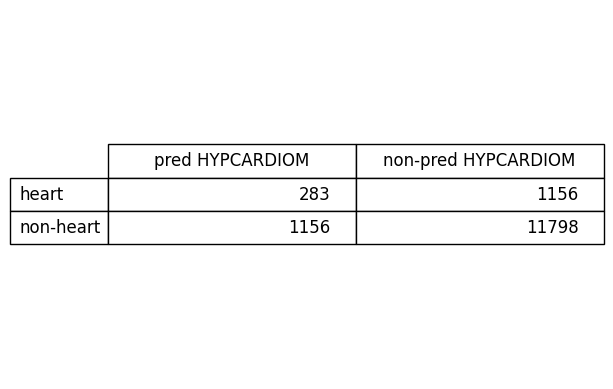

In [1114]:
# plot the contingency table

# sanity check for parameters:
print(f"phenotype = {PHENOTYPE}")
print(f"alpha = {ALPHA}")
print(f"d_max = {D_MAX}")
print(f"alpha_norm = {ALPHA_NORM}")

print(f"PRED_{PHENOTYPE}_DEFINITION: Top {PRED_CAUSAL_DEFINITION}%")
print(f"{TISSUE}_DEFINITION: Top {TISSUE_DEFINITION}%")

# plot p-value fo the Fisher test
print(f"p-value = {pvalue_Fisher} (Fisher test)")

fig, ax = matplotlib.pyplot.subplots(1,1)
table = ax.table(contingency_matrix, rowLabels=[f'{TISSUE}', f'non-{TISSUE}'], colLabels=[f'pred {PHENOTYPE}', f'non-pred {PHENOTYPE}'], loc="center")
ax.axis('tight')
ax.axis('off')
table.set_fontsize(14)
table.scale(1,2)

In [1115]:
proportion1 = x1 / (x1 + x3) # ratio of predicted causal genes that are tissue-enriched
proportion2 = x2 / (x2 + x4) # ratio of all genes that are tissue-enriched

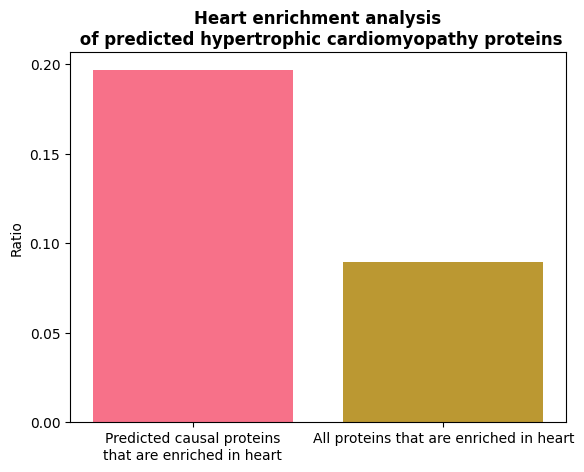

In [1117]:
PHENOTYPE_TITLE = "hypertrophic cardiomyopathy"
# PHENOTYPE_TITLE = PHENOTYPE

xticks = [f"Predicted causal proteins\nthat are enriched in {TISSUE}", 
          f"All proteins that are enriched in {TISSUE}"]

matplotlib.pyplot.bar(x=xticks, height=[proportion1, proportion2], color=seaborn.husl_palette())
matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted {PHENOTYPE_TITLE} proteins", weight='bold', fontsize=12)
matplotlib.pyplot.yticks(numpy.arange(0, 0.25, 0.05))
matplotlib.pyplot.ylabel("Ratio")

matplotlib.pyplot.savefig(f"/home/kubicaj/calc/Figures/Tissue-enrichment/{PHENOTYPE}", dpi=1000)